Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'DOM'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
30691,DOM,"Sulfur_Falls,Ghitu_Journeymage,Keldon_Warcalle...","Blink_of_an_Eye,The_Eldest_Reborn,Jodah,_Archm...","Cast_Down,Garna,_the_Bloodflame,Lingering_Phan...","Knight_of_Grace,Eviscerate,Adamant_Will,Fiery_...","Fight_With_Fire,Academy_Drake,Valduk,_Keeper_o...","Fight_With_Fire,The_First_Eruption,Fervent_Str...","Grunn,_the_Lonely_King,Gideon's_Reproach,D'Ave...","Vicious_Offering,Shivan_Fire,Kazarov,_Sengir_P..."
30705,DOM,"Llanowar_Elves,Urgoros,_the_Empty_One,Blessed_...","Wizard's_Lightning,Valduk,_Keeper_of_the_Flame...","Karn's_Temporal_Sundering,Blackblade_Reforged,...","The_Eldest_Reborn,Sentinel_of_the_Pearl_Triden...","Settle_the_Score,Settle_the_Score,Drudge_Senti...","Fight_With_Fire,Helm_of_the_Host,Goblin_Barrag...","Raff_Capashen,_Ship's_Mage,Cast_Down,Sergeant-...","Seal_Away,Jodah,_Archmage_Eternal,Gilded_Lotus..."
30706,DOM,"Hallar,_the_Firefletcher,Llanowar_Envoy,Elfham...","Urgoros,_the_Empty_One,Josu_Vess,_Lich_Knight,...","Untamed_Kavu,Grow_from_the_Ashes,Song_of_Freya...","Untamed_Kavu,Shivan_Fire,Mammoth_Spider,Sporec...","Arvad_the_Cursed,Vicious_Offering,Fungal_Infec...","Knight_of_Malice,Ancient_Animus,Two-Headed_Gia...","Verix,_Bladewing,Knight_of_Grace,Rampaging_Cyc...","Karn's_Temporal_Sundering,In_Bolas's_Clutches,..."
30710,DOM,"Juggernaut,Juggernaut,Traxos,_Scourge_of_Kroog...","Steel_Leaf_Champion,Evra,_Halcyon_Witness,Sapr...","Steel_Leaf_Champion,Serra_Angel,Llanowar_Scout...","Fight_With_Fire,Shivan_Fire,Baloth_Gorger,Ling...","Settle_the_Score,Eviscerate,Vicious_Offering,Y...","Skizzik,Vicious_Offering,On_Serra's_Wings,Vald...","Cast_Down,Cast_Down,Teshar,_Ancestor's_Apostle...","Settle_the_Score,Vicious_Offering,Knight_of_Gr..."
30715,DOM,"Slimefoot,_the_Stowaway,Dark_Bargain,Saproling...","Multani,_Yavimaya's_Avatar,Aryel,_Knight_of_Wi...","Goblin_Chainwhirler,Hallar,_the_Firefletcher,R...","Baird,_Steward_of_Argive,Valduk,_Keeper_of_the...","Territorial_Allosaurus,Baloth_Gorger,Hallar,_t...","Karn's_Temporal_Sundering,Vicious_Offering,Lin...","The_Eldest_Reborn,Lingering_Phantom,Drudge_Sen...","Grand_Warlord_Radha,Goblin_Barrage,Seismic_Shi..."


In [8]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [7]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [8]:
draftCount = 0
player = 'human' # normally should be: "human", but can also be "bot1" or any other bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  194.2791121006012
Total drafts analyzed:  51742


In [9]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

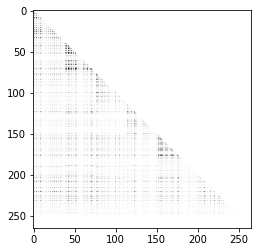

In [10]:
plt.imshow(pairs, cmap="Greys");

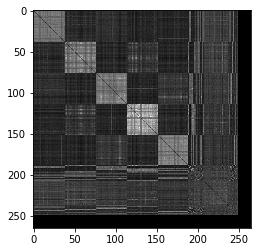

In [11]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [12]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        print(cardlist[i])
        del cardpicks[cardlist[i]] # Remove undrafted cards from the dictionary

plains
island
swamp
mountain
forest
teferi_timebender
temporal_machinations
niambi_faithful_healer
teferi's_sentinel
meandering_river
chandra_bold_pyromancer
chandra's_outburst
karplusan_hound
pyromantic_pilgrim
timber_gorge
firesong_and_sunspeaker


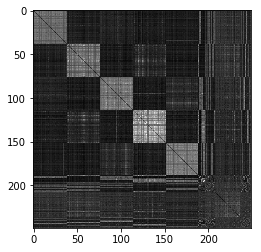

In [13]:
# Remove missing cards from other arrays
# (I make copies of both arrays for some reason, just in case)

dist2 = dist.copy()
dist2 = dist2[freq>0,:]
dist2 = dist2[:,freq>0] # For some reason if I try to subset both rows and columns together, it outputs something stupid
plt.imshow(dist2, cmap="Greys");

freq2 = freq[freq>0]

In [14]:
embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.0001)
fit = embedding.fit_transform(dist2)

In [15]:
df = pd.DataFrame({
        'avg'   : [np.mean(cardpicks[card]) for card in cardpicks],
        'var'   : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq2[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
karn_scion_of_urza,1.408012,0.434417,674,C,mythic,1,0.074315,-0.343360,1605
adamant_will,8.621917,8.607100,5393,W,common,0,-0.503438,-0.319517,15214
aven_sentry,6.434005,7.028076,4417,W,common,0,-0.494902,-0.418015,12140
baird_steward_of_argive,2.454266,1.531989,2274,W,uncommon,1,-0.429616,-0.405379,7575
benalish_honor_guard,7.729976,9.180742,8003,W,common,0,-0.552110,-0.294247,21495


In [16]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('Arseny/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('Arseny/distances_'+setName+'.csv', dist2, delimiter=",")

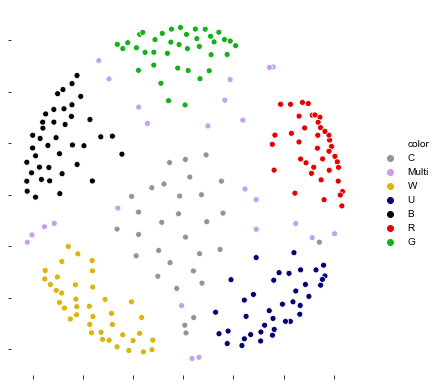

In [17]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

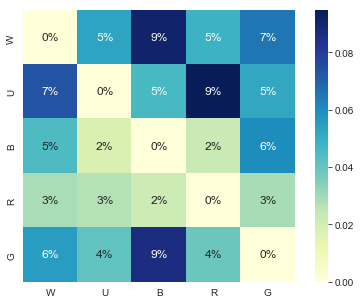

In [18]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [19]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
josu_vess_lich_knight,1.0,0.0,1054,B,rare,1,-0.625664,0.052649,2809
history_of_benalia,1.0,0.0,467,W,mythic,0,-0.361498,-0.473082,1244
lyra_dawnbringer,1.0,0.0,609,W,mythic,1,-0.159952,-0.610499,1717
naru_meha_master_wizard,1.0,0.0,459,U,mythic,1,0.555277,-0.328674,1332
multani_yavimaya's_avatar,1.0,0.0,518,G,mythic,1,-0.118445,0.503624,1462
demonlord_belzenlok,1.0,0.0,477,B,mythic,1,-0.397360,0.190387,1401
steel_leaf_champion,1.0,0.0,651,G,rare,0,0.122523,0.593608,1628
yawgmoth's_vile_offering,1.0,0.0,582,B,rare,1,-0.484731,0.081749,1563
territorial_allosaurus,1.0,0.0,721,G,rare,0,0.208673,0.578954,1983
verix_bladewing,1.0,0.0,519,R,mythic,1,0.475438,0.358735,1313


In [20]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
the_antiquities_war,8.430676,18.791988,2308,U,rare,0,0.128622,-0.456237,6197
lich's_mastery,8.631320,18.772081,1424,B,rare,1,-0.363645,0.053560,4174
primevals'_glorious_rebirth,8.331280,18.693571,2110,Multi,rare,1,-0.515746,-0.111214,4706
the_mending_of_dominaria,8.034586,17.236398,2660,G,rare,0,0.006720,0.348784,7743
rona_disciple_of_gix,8.062534,16.848012,3694,Multi,uncommon,1,-0.261947,-0.051729,11403
cabal_stronghold,10.023529,16.278313,2295,B,rare,0,-0.245550,0.157568,6082
haphazard_bombardment,8.577093,15.849784,908,R,rare,0,0.362262,0.095651,2577
sulfur_falls,9.353173,15.442446,2285,Multi,rare,0,0.448838,-0.111904,5422
isolated_chapel,8.466383,15.047165,2112,Multi,rare,0,-0.555280,-0.124470,4756
jhoira_weatherlight_captain,4.904412,14.917333,1632,Multi,mythic,1,0.514481,-0.166679,4208
